# Activity 5

## Grayscale Segmentation

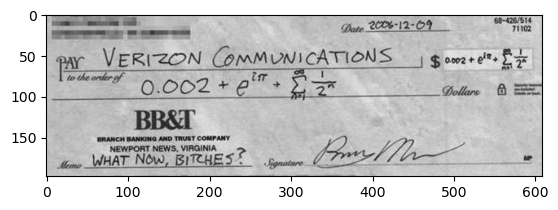

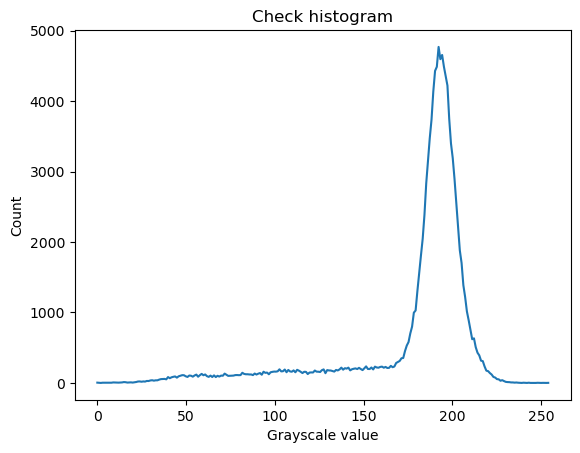

In [15]:
import numpy as np
import matplotlib.pyplot as plt

check = plt.imread('cropped_grayscale_check.jpg')
plt.imshow(check, cmap='gray')
plt.show()

count, cells = np.histogram(check.flatten(),256)    # flatten check image to make it 1d
plt.plot(cells[:-1],count)
plt.xlabel('Grayscale value')
plt.ylabel('Count')
plt.title('Check histogram')
# plt.savefig('check_hist.png')
plt.show()

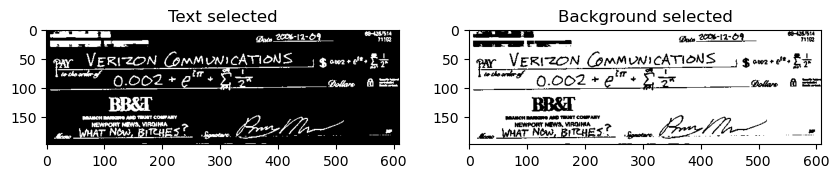

In [17]:
ROI_less = check < 150          # select text
ROI_greater = check > 150       # select background

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(121)
plt.title('Text selected')
plt.imshow(ROI_less, cmap='gray')

ax = fig.add_subplot(122)
plt.title('Background selected')
plt.imshow(ROI_greater, cmap='gray')

plt.show()

# plt.imsave('ROI_text.png', ROI_less, cmap='gray')
# plt.imsave('ROI_bg.png', ROI_greater, cmap='gray')

## Color segmentation

In [19]:
def img_norm(img):     # normalize an image
    img = img/255      # to avoid int limit error
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    I = R+G+B
    I = np.where(I==0, 10e10, I)  # to avoid dividing by zero (which gives a large number, so set it to a large number already)
    R_norm = R/I
    G_norm = G/I
    B_norm = B/I
    img_norm = np.dstack([R_norm,G_norm,B_norm])
    return img_norm

def NCC(img, desc = None):    # plot the normalized chromaticity coordinates of an image, desc input is just for legend
    x = np.linspace(0,255,255)
    y = -x+1                      # diagonal line where values can't go past
    
    img_normed = img_norm(img)    # normalize input image (if already normalized, this does basically nothing)
    
    # plot R and G axes
    if desc == None:    # if no desc given, no legend
        plt.plot(img_normed[:,:,0].flatten(),img_normed[:,:,1].flatten(), '.')    # plot R and G axes
    else:               # if desc given, show legend
        plt.plot(img_normed[:,:,0].flatten(),img_normed[:,:,1].flatten(), '.', label=desc)    
        plt.legend()
    plt.plot(y, c='gray')    # draw the diagonal line where values can't go past
    plt.xlabel('r')
    plt.ylabel('g')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title('Normalized chromaticity coordinates')
    
def img_show(img):
    img_normed = img_norm(img)

    plt.figure(figsize=[10,5])

    plt.subplot(121)
    plt.title('Original')
#     plt.axis('off')
    plt.imshow(img)

    plt.subplot(122)
    plt.title('Normalized')
#     plt.axis('off')
    plt.imshow(img_normed)

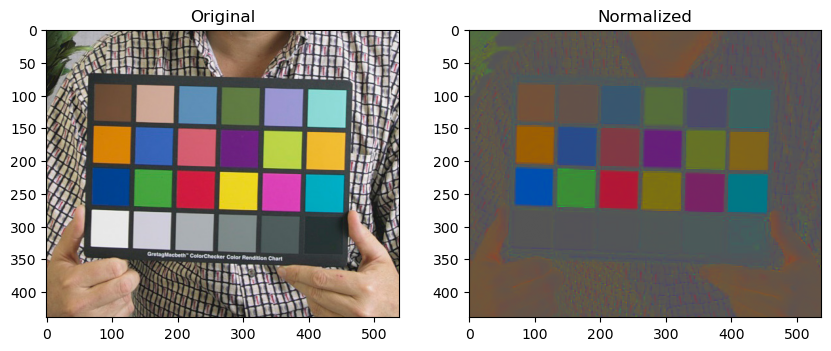

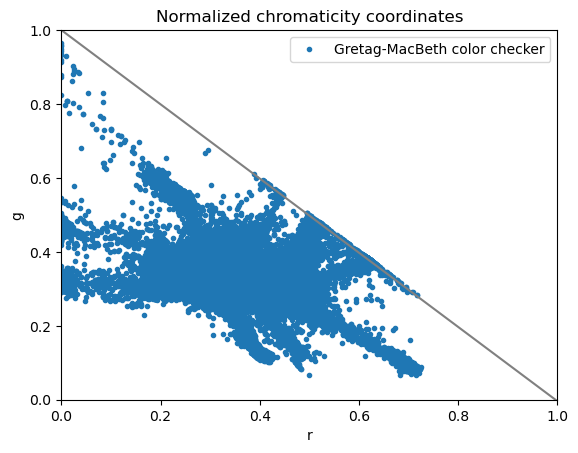

In [21]:
# try with the Gretag-MacBeth color checker

color_checker = plt.imread('Gretag-Macbeth_ColorChecker.jpg')

img_show(color_checker)
# plt.savefig('Gretag-Macbeth.png')
plt.show()

NCC(color_checker,'Gretag-MacBeth color checker')
# plt.savefig('Gretag-Macbeth NCC.png')
plt.show()


### Parametric segmentation

In [23]:
def gaussian_PDF(img, ROI):
    # normalize
    img_normed = img_norm(img)
    ROI_normed = img_norm(ROI)
    
    # normalized image values
    r = img_normed[:,:,0]
    g = img_normed[:,:,1]
    
    # ROI values
    ROI_r = ROI_normed[:,:,0]
    ROI_g = ROI_normed[:,:,1]
    
    # parameters from ROI values
    mu_r = np.mean(ROI_r)
    mu_g = np.mean(ROI_g)
    sigma_r = np.std(ROI_r)
    sigma_g = np.std(ROI_g)
    
    # individual probabality of normalized image to be in red and green space of ROI
    gauss_r = 1/(sigma_r*np.sqrt(2*np.pi))*np.exp(-(r-mu_r)**2/(2*sigma_r**2))
    gauss_g = 1/(sigma_g*np.sqrt(2*np.pi))*np.exp(-(g-mu_g)**2/(2*sigma_g**2))
    
    # joint probability
    return gauss_r*gauss_g

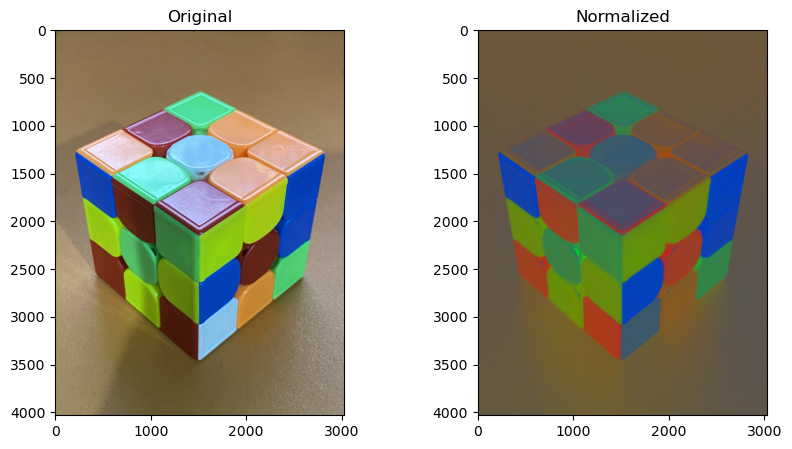

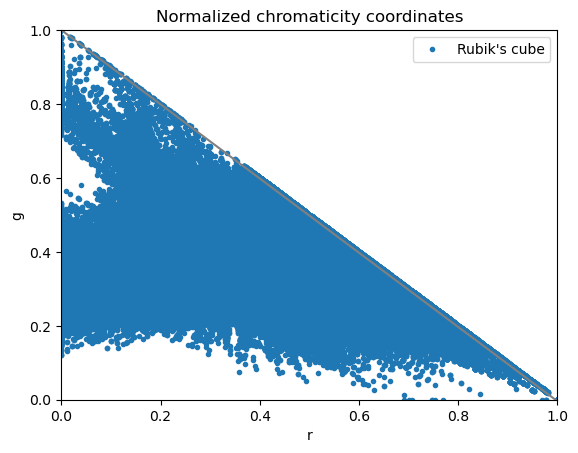

In [25]:
# i will try to segment each color of the cube

cube = plt.imread('rubikscube.png')
cube_norm = img_norm(cube)

img_show(cube)
# plt.savefig('cube.png')
plt.show()

NCC(cube, desc='Rubik\'s cube')
# plt.savefig('cube NCC.png')
plt.show()

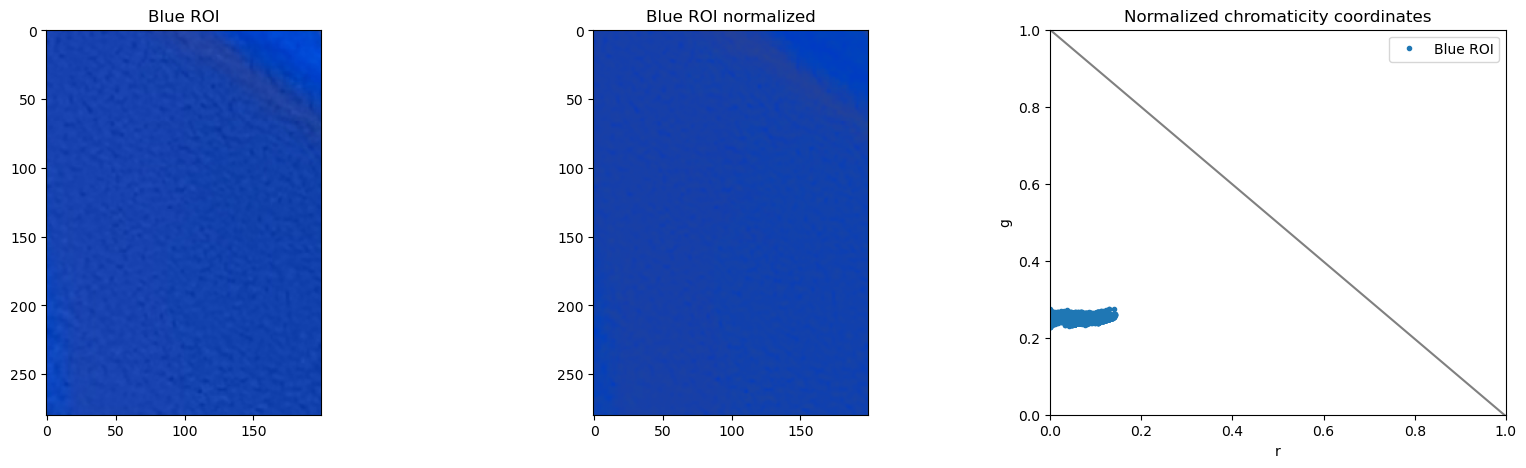

In [27]:
# test with blue ROI

blue_ROI = cube[1470:1750,300:500]
blue_ROI_norm = img_norm(blue_ROI)

fig = plt.figure(figsize=[20,5])

fig.add_subplot(131)
plt.imshow(blue_ROI)
plt.title('Blue ROI')

fig.add_subplot(132)
plt.imshow(blue_ROI_norm)
plt.title('Blue ROI normalized')

fig.add_subplot(133)
NCC(blue_ROI,'Blue ROI')

# plt.savefig('blue ROI.png')
plt.show()

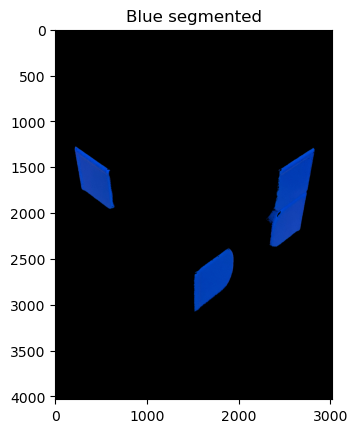

In [29]:
blue_gauss = gaussian_PDF(cube, blue_ROI)

blue_mask = blue_gauss < 10e-10     # threshold for probability
r_cube = cube[:,:,0]*blue_mask
g_cube = cube[:,:,1]*blue_mask
b_cube = cube[:,:,2]*blue_mask
cube_segmented = np.dstack((r_cube,g_cube,b_cube))

plt.imshow(cube_segmented)
plt.title('Blue segmented')
plt.savefig('blue segmented.png')

plt.show()

In [47]:
# Now define function, and try other colors

def parametric(img, ROI, thresh):
    img_gauss = gaussian_PDF(img, ROI) # get probability of image in ROI

    img_mask = img_gauss > thresh   # threshold
    r_img = img[:,:,0]*img_mask
    g_img = img[:,:,1]*img_mask
    b_img = img[:,:,2]*img_mask
    img_segmented = np.dstack((r_img,g_img,b_img))

    plt.imshow(img_segmented)
    
def ROI_get(img,x1,y1,x2,y2):
    return img[x1:x2,y1:y2]

def ROI_show(ROI,desc=None):
    ROI_norm = img_norm(ROI)

    fig = plt.figure(figsize=[15,5])

    fig.add_subplot(131)
    plt.imshow(ROI)
    plt.title(desc)

    fig.add_subplot(132)
    plt.imshow(ROI_norm)
    plt.title('{} normalized'.format(desc))

    fig.add_subplot(133)
    NCC(ROI,desc)

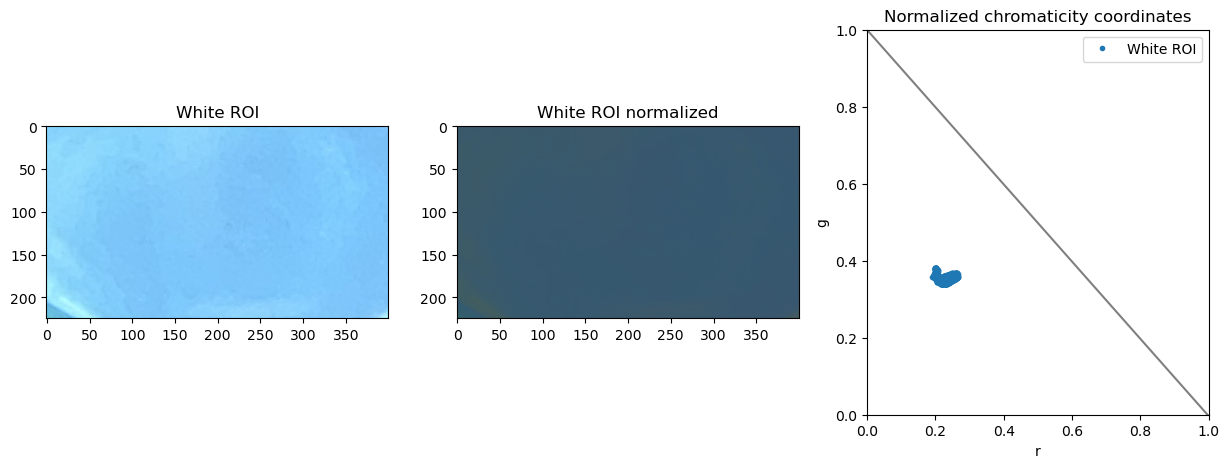

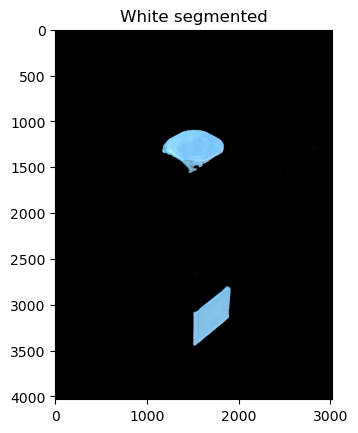

In [32]:
white_ROI = ROI_get(cube,1175,1300,1400,1700)

ROI_show(white_ROI,'White ROI')
# plt.savefig('white ROI.png')
plt.show()

parametric(cube,white_ROI,10e-10)
plt.title('White segmented')
# plt.savefig('white segmented.png')
plt.show()

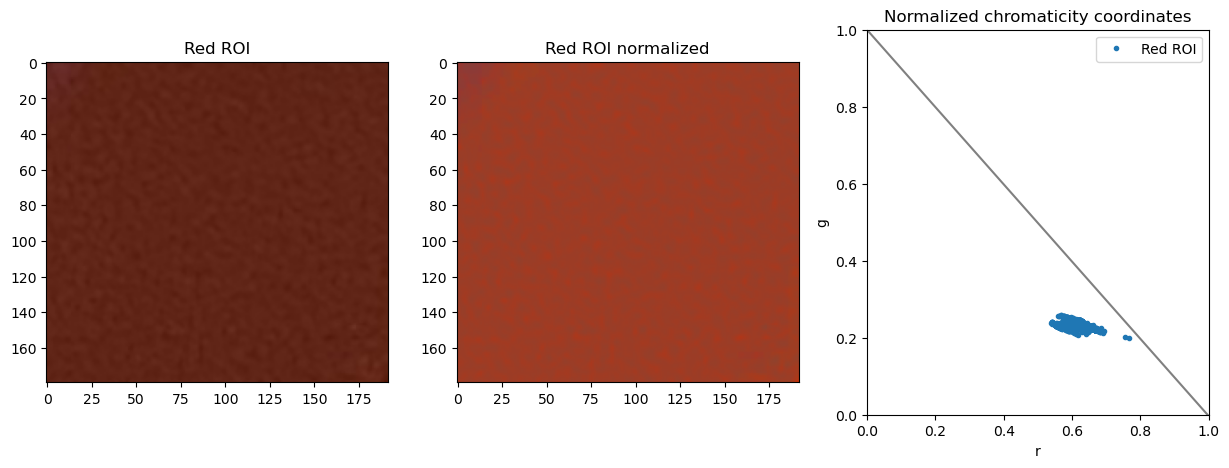

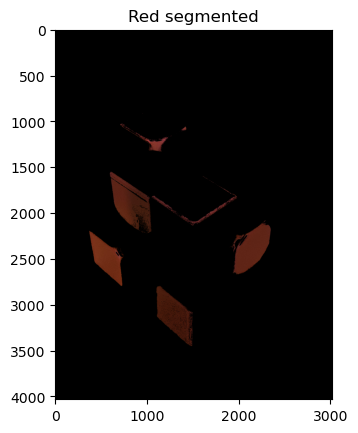

In [33]:
red_ROI = ROI_get(cube,2381,1986,2561,2178)

ROI_show(red_ROI,'Red ROI')
# plt.savefig('red ROI.png')
plt.show()

parametric(cube,red_ROI,10e-10)
plt.title('Red segmented')
# plt.savefig('red segmented.png')
plt.show()

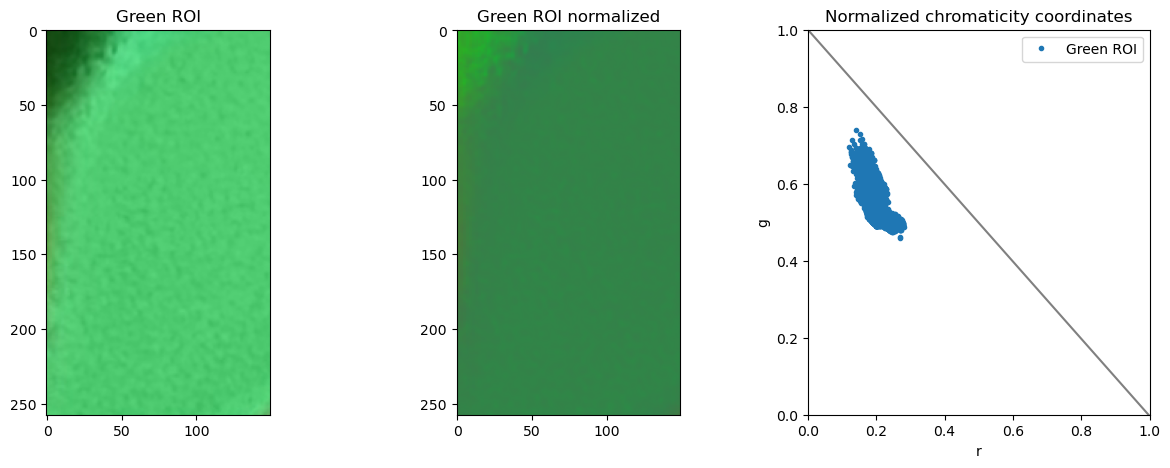

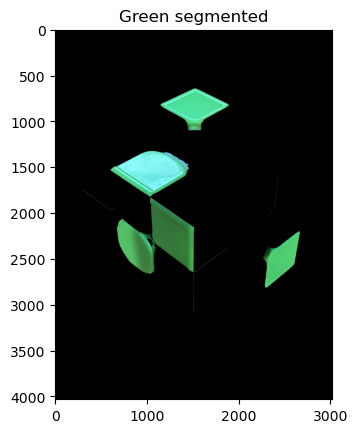

In [34]:
green_ROI = ROI_get(cube,2435,2304,2693,2454)

ROI_show(green_ROI,'Green ROI')
# plt.savefig('green ROI.png')
plt.show()

parametric(cube,green_ROI,10e-10)
plt.title('Green segmented')
# plt.savefig('green segmented.png')
plt.show()

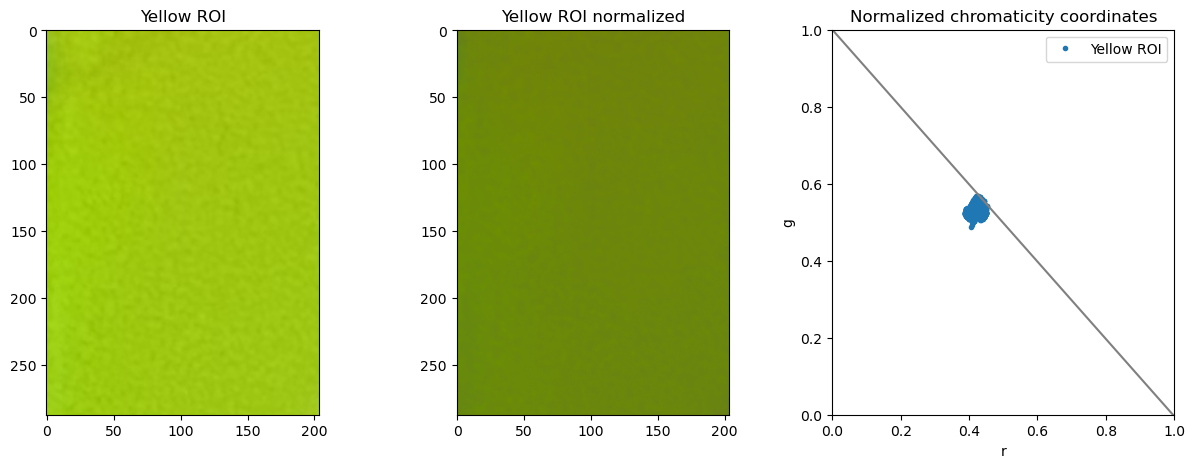

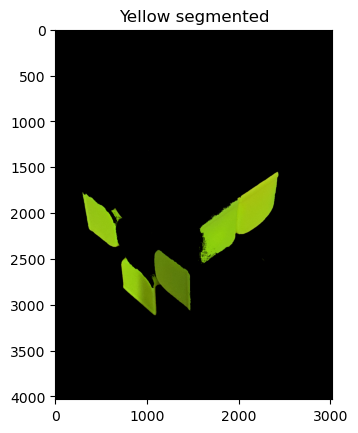

In [35]:
yellow_ROI = ROI_get(cube,1859,1992,2147,2196)

ROI_show(yellow_ROI,'Yellow ROI')
# plt.savefig('yellow ROI.png')
plt.show()

parametric(cube,yellow_ROI,10e-10)
plt.title('Yellow segmented')
# plt.savefig('yellow segmented.png')
plt.show()

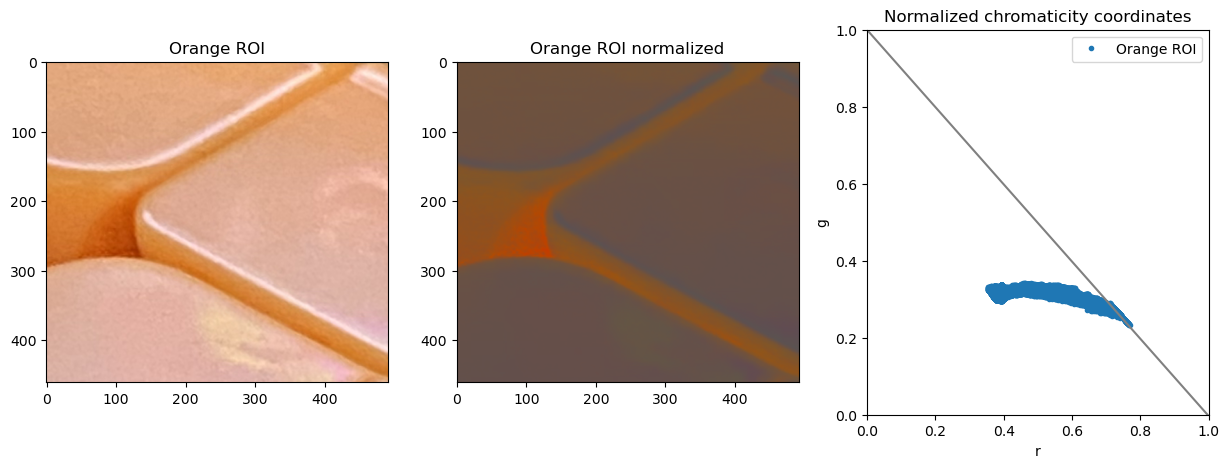

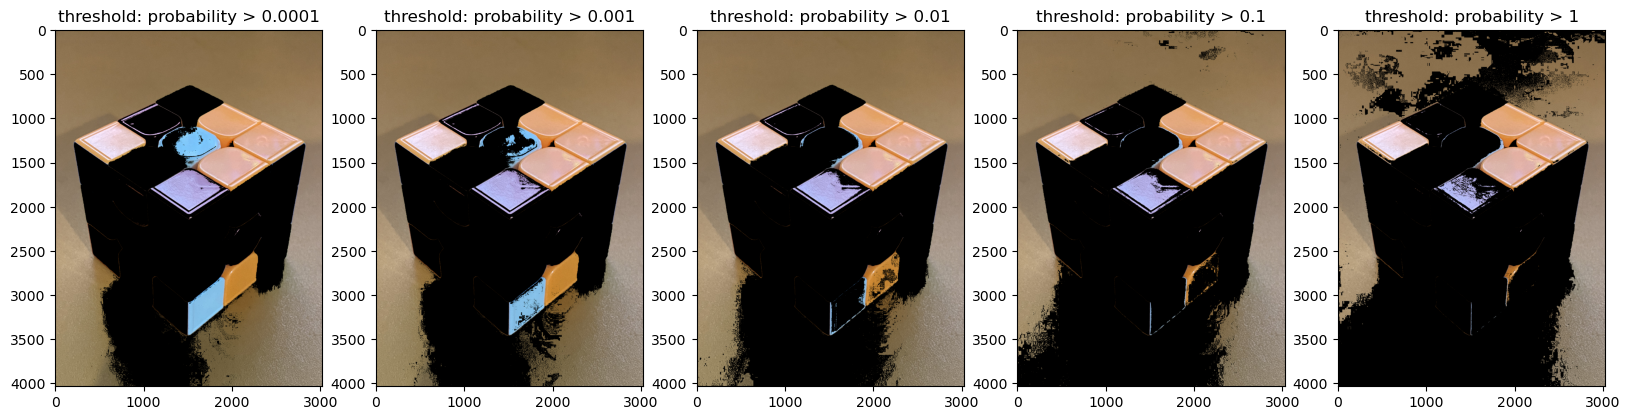

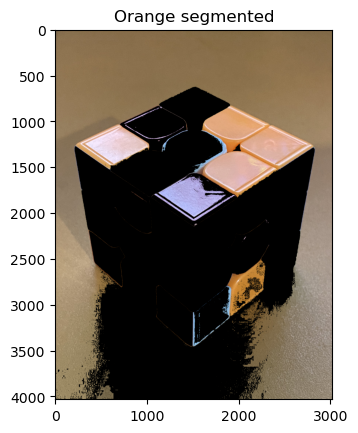

In [36]:
orange_ROI = ROI_get(cube,1050,1884,1511,2376)

ROI_show(orange_ROI,'Orange ROI')
# plt.savefig('orange ROI')
plt.show()

ctr = 151
fig = plt.figure(figsize=(20,5))
for i in [0.0001,0.001,0.01,0.1,1]:
    plt.subplot(ctr)
    parametric(cube,orange_ROI,i)
    plt.title('threshold: probability > {}'.format(i))
    ctr+=1
# plt.savefig('orange thresholds')
plt.show()

parametric(cube,orange_ROI,0.01)
plt.title('Orange segmented')
# plt.savefig('orange segmented')
plt.show()    

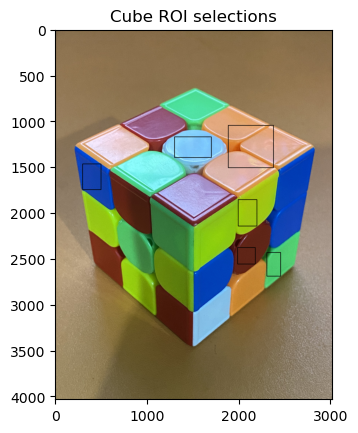

In [37]:
import cv2
cube_ROI_selections = np.copy(cube)
cv2.rectangle(cube_ROI_selections,(300,1470),(500,1750),(0,0,0),5)    # blue ROI
cv2.rectangle(cube_ROI_selections,(1300,1175),(1700,1400),(0,0,0),5)    # white ROI
cv2.rectangle(cube_ROI_selections,(1986,2381),(2178,2561),(0,0,0),5)    # red ROI
cv2.rectangle(cube_ROI_selections,(2304,2435),(2454,2693),(0,0,0),5)    # green ROI
cv2.rectangle(cube_ROI_selections,(1992,1859),(2196,2147),(0,0,0),5)    # yellow ROI
cv2.rectangle(cube_ROI_selections,(1884,1050),(2376,1511),(0,0,0),5)    # orange ROI
plt.imshow(cube_ROI_selections)
plt.title('Cube ROI selections')
# plt.savefig('cube ROI selections.png')
plt.show()

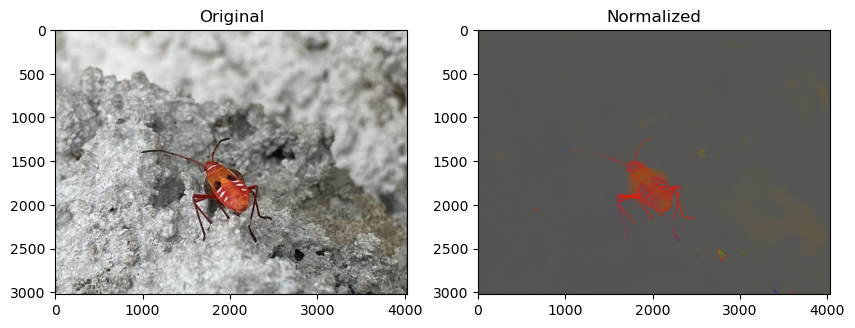

In [38]:
# i took a photo of this cotton strainer bug

insect = plt.imread('bug.png')

img_show(insect)
# plt.savefig('insect.png')
plt.show()

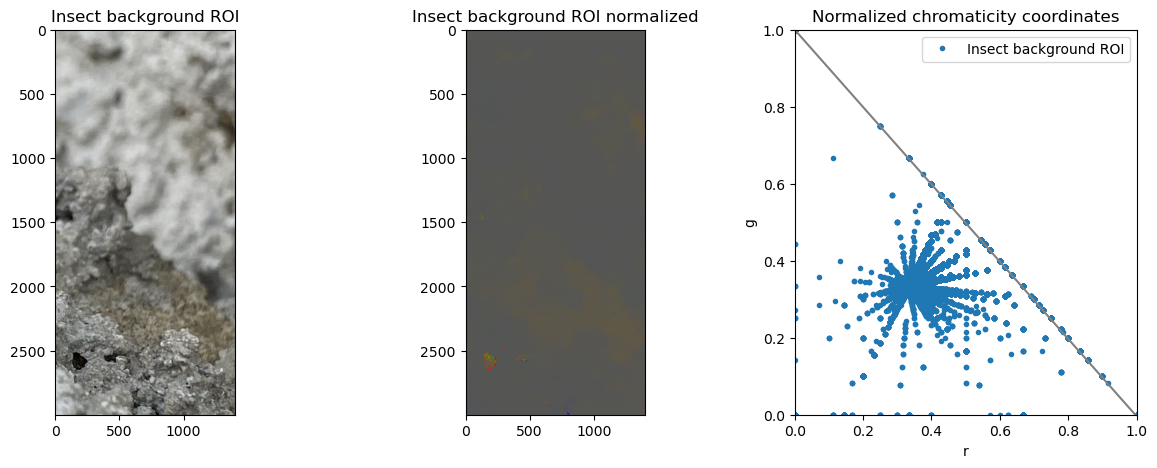

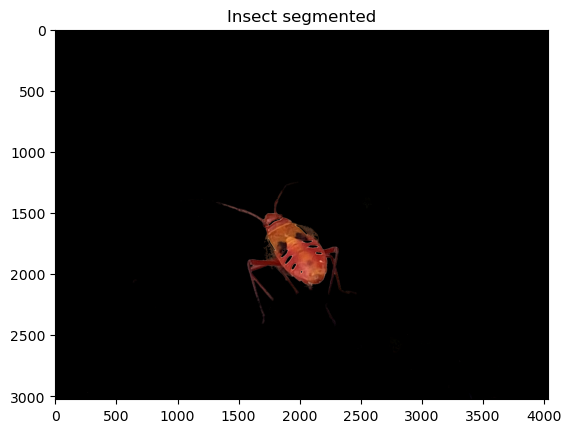

In [46]:
insect_ROI = ROI_get(insect,0,2600,3000,4000)

ROI_show(insect_ROI,'Insect background ROI')
# plt.savefig('insect ROI.png')
plt.show()

parametric(insect,insect_ROI,10e-10)
plt.title('Insect segmented')
# plt.savefig('insect segmented.png')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


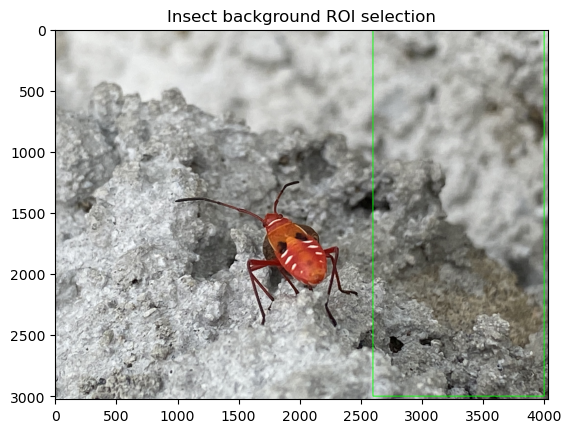

In [40]:
insect_ROI_selection = np.copy(insect)
cv2.rectangle(insect_ROI_selection,(2600,0),(4000,3000),(0,255,0),5)

plt.imshow(insect_ROI_selection)
plt.title('Insect background ROI selection')
# plt.savefig('insect bg ROI selection')
plt.show()

## Non-parametric segmentation

In [41]:
bins = 32

r_int = np.round(cube_norm[:,:,0]*(bins-1)+1)
g_int = np.round(cube_norm[:,:,1]*(bins-1)+1)
colors = g_int.flatten() + (r_int.flatten()-1)*bins

# hist = np.zeros((bins,bins))

# for row in range(bins):
#     for col in range(bins-row):
#         hist[row,col] = len(np.where(colors==(col+(row-1)*bins)))
        
# plt.imshow(hist,cmap='gray')
# plt.show()

r_int

array([[14., 14., 14., ..., 14., 14., 14.],
       [14., 14., 14., ..., 14., 14., 14.],
       [13., 13., 14., ..., 14., 14., 14.],
       ...,
       [13., 13., 13., ..., 12., 12., 12.],
       [13., 13., 13., ..., 12., 12., 12.],
       [13., 13., 13., ..., 12., 12., 12.]], dtype=float32)

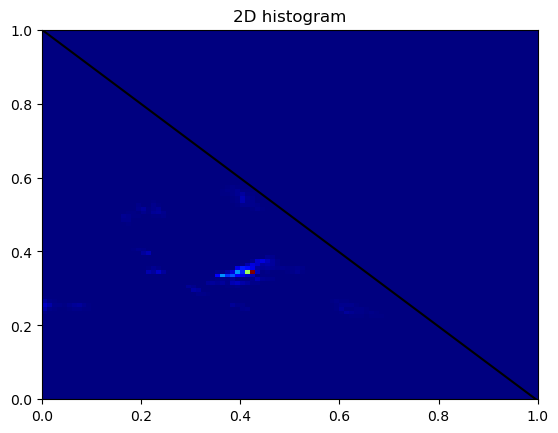

In [43]:
r_cube_flat = cube_norm[:,:,0].flatten()
g_cube_flat = cube_norm[:,:,1].flatten()

x = np.linspace(0,255,255)
y = -x+1
plt.plot(y,c='black')
plt.hist2d(r_cube_flat,g_cube_flat,bins=100,cmap='jet')
plt.title("2D histogram")
plt.show()

In [59]:
import cv2

def nonparametric(img,ROI,bins):
    # Converting the image to HSV color space
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Extracting the hue channel
    img_h = img_hsv[:, :, 0]

    # Calculating the histogram of the hue channel
    hist = cv2.calcHist([img_h], [0], ROI[:, :, 1], [bins], [0, bins])
    cv2.normalize(hist, hist, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Performing back projection using the histogram and the hue channel
    backproj = cv2.calcBackProject([img_h], [0], hist, [0, 180], scale=1)

    # Applying a binary threshold to the back projection
    ret, thresh = cv2.threshold(backproj, 0, 255, cv2.THRESH_BINARY)

#     # Applying a morphological opening to remove small objects
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
#     opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # Isolating the pixels that matches the patch
    mask = backproj > 1
    red = image[:,:,0]*mask
    green = image[:,:,1]*mask
    blue = image[:,:,2]*mask
    image_masked = np.dstack((blue,green,red))
    image_masked = cv2.cvtColor(image_masked, cv2.COLOR_BGR2RGB)

    fig = plt.figure(figsize=(20, 12))
    
    plt.imshow(image_masked)
    plt.title('Image segmented')

In [126]:
def nonparametric_seg(image_name,x1,x2,y1,y2, bin_size):
    # Reading the image
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Defining the green patch
    roi = np.zeros_like(image)
    roi[x1:x2, y1:y2, :] = image[x1:x2, y1:y2, :]

    # Draw a rectangle around the ROI on the original image
    image_with_roi = image.copy()
    image_with_roi = cv2.rectangle(image_with_roi, (y1, x1), (y2, x2), (0, 255, 0), 2)

    # Converting the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Extracting the hue channel
    hue = hsv[:, :, 0]

    # Calculating the histogram of the hue channel
    hist = cv2.calcHist([hue], [0], roi[:, :, 1], [bin_size], [0, bin_size])
    cv2.normalize(hist, hist, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Performing back projection using the histogram and the hue channel
    backproj = cv2.calcBackProject([hue], [0], hist, [0, 180], scale=1)

    # Applying a binary threshold to the back projection
    ret, thresh = cv2.threshold(backproj, 0, 255, cv2.THRESH_BINARY)

    # Applying a morphological opening to remove small objects
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # Isolating the pixels that matches the patch
    mask = backproj > 1
    red = image[:,:,0]*mask
    green = image[:,:,1]*mask
    blue = image[:,:,2]*mask
    image_masked = np.dstack((red,green,blue))

    fig, axs = plt.subplots(1, 3, figsize=(20, 12))

    axs[0].imshow(image_with_roi)
    axs[0].set_title('Original image with boxed ROI')

    axs[1].imshow(roi)
    axs[1].set_title('Binary image')
    
    axs[2].imshow(image_masked)
    axs[2].set_title('Final nonparametrically segmented image')

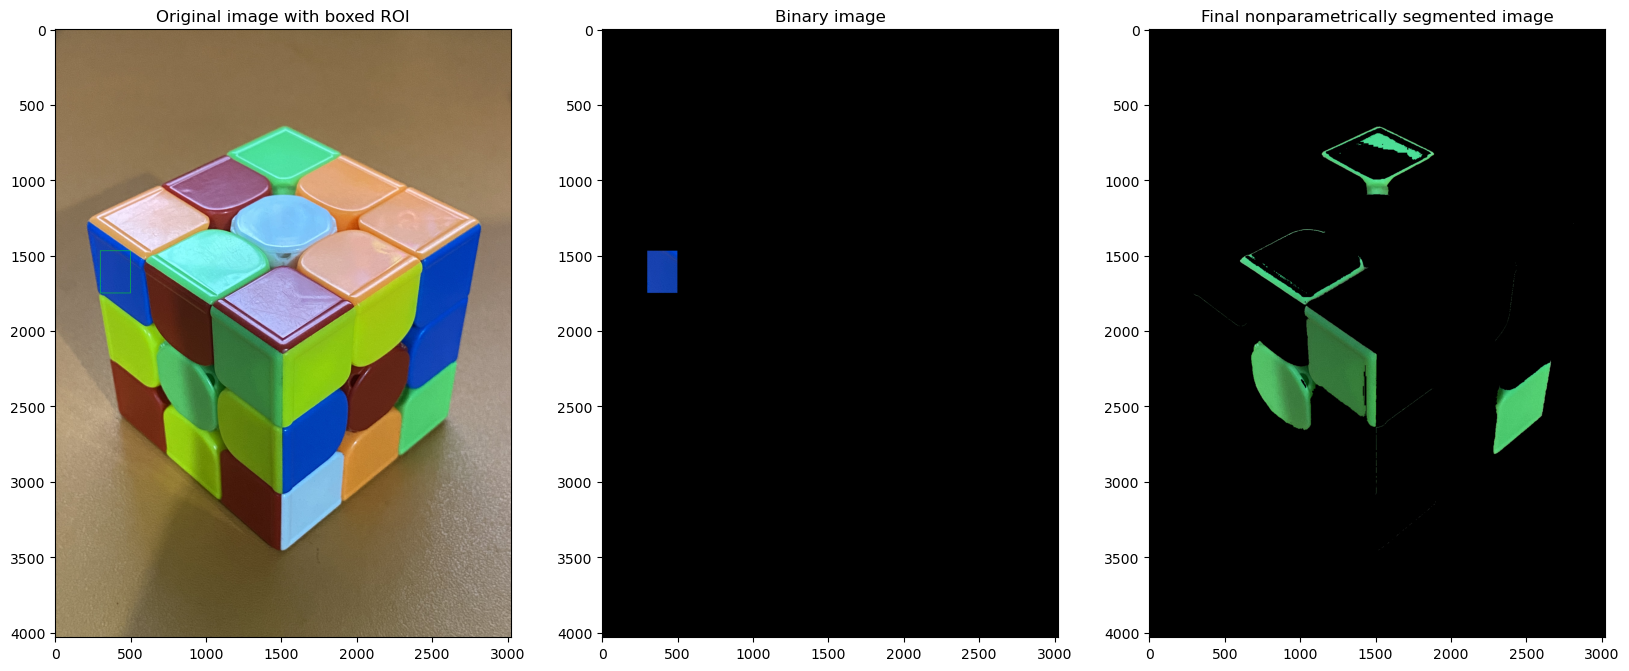

In [127]:
nonparametric_seg('rubikscube.png',1470,1750,300,500,32)